In [76]:
# Import thư viện
import os
import pyodbc
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import json

# Thiết lập thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# Đường dẫn media_root
media_root = r"C:\Users\DELL\OneDrive - Hanoi University of Science and Technology\Desktop\Django\Demo\mysite\media\plant_images"

Sử dụng thiết bị: cpu


In [77]:
# Kết nối SQL Server để lấy danh sách ảnh
server = 'DESKTOP-NDJJABF\SQLEXPRESS'
database = 'plant_disease'
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'

conn = pyodbc.connect(connection_string)
# Sửa truy vấn để lấy cả dataset_type
query = "SELECT image, disease, dataset_type FROM plant_health_app_plantmodel WHERE dataset_type = 'train' OR dataset_type = 'valid'"
df = pd.read_sql(query, conn)
conn.close()

# Tách dữ liệu train và valid
train_df = df[df['dataset_type'] == 'train']
val_df = df[df['dataset_type'] == 'valid']

# Lấy danh sách class_names từ cột disease
class_names = sorted(df['disease'].unique())
num_classes = len(class_names)

# Lưu class_names
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

# Tạo danh sách ảnh và nhãn
train_image_paths = [os.path.join(media_root, row['image']) for _, row in train_df.iterrows()]
train_labels = [class_names.index(row['disease']) for _, row in train_df.iterrows()]
val_image_paths = [os.path.join(media_root, row['image']) for _, row in val_df.iterrows()]
val_labels = [class_names.index(row['disease']) for _, row in val_df.iterrows()]

print(f"Số lượng ảnh train: {len(train_image_paths)}")
print(f"Số lượng ảnh validation: {len(val_image_paths)}")
print(f"Số lớp: {num_classes}")

C:\Users\DELL\AppData\Local\Temp\ipykernel_8084\3201133735.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Số lượng ảnh train: 70295
Số lượng ảnh validation: 17572
Số lớp: 21


In [78]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.valid_indices = []
        print("Đang kiểm tra ảnh hợp lệ...")
        for idx, img_path in enumerate(self.image_paths):
            try:
                with Image.open(img_path) as img:
                    img.verify()
                self.valid_indices.append(idx)
            except Exception as e:
                print(f"Lỗi khi mở ảnh {img_path}: {e}")
        print(f"Số ảnh hợp lệ: {len(self.valid_indices)}/{len(self.image_paths)}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        true_idx = self.valid_indices[idx]
        img_path = self.image_paths[true_idx]
        label = self.labels[true_idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Lỗi khi mở ảnh trong __getitem__: {img_path}: {e}")
            raise RuntimeError(f"Không thể mở ảnh {img_path}.")

        if self.transform:
            try:
                image = self.transform(image)
            except Exception as e:
                print(f"Lỗi khi biến đổi ảnh {img_path}: {e}")
                raise RuntimeError(f"Không thể biến đổi ảnh {img_path}.")

        return image, label

In [84]:
# Định nghĩa biến đổi ảnh
start_transform_time = time.time()
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
transform_time = time.time() - start_transform_time
print(f"Thời gian định nghĩa biến đổi ảnh: {transform_time:.2f} giây")

# Cập nhật PlantDiseaseDataset để theo dõi tiến trình đơn giản
class PlantDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.valid_indices = []
        print(f"Đang kiểm tra và biến đổi {len(image_paths)} ảnh...")
        start_check_time = time.time()
        total_images = len(image_paths)
        for idx, img_path in enumerate(image_paths):
            if idx % 1000 == 0 or idx == total_images - 1:  # In tiến trình sau mỗi 1000 ảnh hoặc khi hoàn thành
                progress = (idx + 1) / total_images * 100
                print(f"Tiến trình: {progress:.1f}% ({idx + 1}/{total_images} ảnh)")
            try:
                with Image.open(img_path) as img:
                    img.verify()
                self.valid_indices.append(idx)
            except Exception as e:
                print(f"Lỗi khi mở ảnh {img_path}: {e}")
        check_time = time.time() - start_check_time
        print(f"Thời gian kiểm tra ảnh: {check_time:.2f} giây")
        print(f"Số ảnh hợp lệ: {len(self.valid_indices)}/{len(image_paths)}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        true_idx = self.valid_indices[idx]
        img_path = self.image_paths[true_idx]
        label = self.labels[true_idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Lỗi khi mở ảnh trong __getitem__: {img_path}: {e}")
            raise RuntimeError(f"Không thể mở ảnh {img_path}.")

        if self.transform:
            try:
                image = self.transform(image)
            except Exception as e:
                print(f"Lỗi khi biến đổi ảnh {img_path}: {e}")
                raise RuntimeError(f"Không thể biến đổi ảnh {img_path}.")

        return image, label

Thời gian định nghĩa biến đổi ảnh: 0.01 giây


In [85]:
# Tạo dataset và DataLoader với theo dõi tiến trình
start_dataset_time = time.time()
train_dataset = PlantDiseaseDataset(train_image_paths, train_labels, transform=data_transforms['train'])
val_dataset = PlantDiseaseDataset(val_image_paths, val_labels, transform=data_transforms['val'])
dataset_time = time.time() - start_dataset_time
print(f"Thời gian tạo dataset: {dataset_time:.2f} giây")

start_loader_time = time.time()
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, drop_last=True)
loader_time = time.time() - start_loader_time
print(f"Thời gian tạo DataLoader: {loader_time:.2f} giây")

print(f"Số batch trong train_loader: {len(train_loader)}")
print(f"Số batch trong val_loader: {len(val_loader)}")

Đang kiểm tra và biến đổi 70295 ảnh...
Tiến trình: 0.0% (1/70295 ảnh)
Tiến trình: 1.4% (1001/70295 ảnh)
Tiến trình: 2.8% (2001/70295 ảnh)
Tiến trình: 4.3% (3001/70295 ảnh)
Tiến trình: 5.7% (4001/70295 ảnh)
Tiến trình: 7.1% (5001/70295 ảnh)
Tiến trình: 8.5% (6001/70295 ảnh)
Tiến trình: 10.0% (7001/70295 ảnh)
Tiến trình: 11.4% (8001/70295 ảnh)
Tiến trình: 12.8% (9001/70295 ảnh)
Tiến trình: 14.2% (10001/70295 ảnh)
Tiến trình: 15.6% (11001/70295 ảnh)
Tiến trình: 17.1% (12001/70295 ảnh)
Tiến trình: 18.5% (13001/70295 ảnh)
Tiến trình: 19.9% (14001/70295 ảnh)
Tiến trình: 21.3% (15001/70295 ảnh)
Tiến trình: 22.8% (16001/70295 ảnh)
Tiến trình: 24.2% (17001/70295 ảnh)
Tiến trình: 25.6% (18001/70295 ảnh)
Tiến trình: 27.0% (19001/70295 ảnh)
Tiến trình: 28.5% (20001/70295 ảnh)
Tiến trình: 29.9% (21001/70295 ảnh)
Tiến trình: 31.3% (22001/70295 ảnh)
Tiến trình: 32.7% (23001/70295 ảnh)
Tiến trình: 34.1% (24001/70295 ảnh)
Tiến trình: 35.6% (25001/70295 ảnh)
Tiến trình: 37.0% (26001/70295 ảnh)
Tiến trìn

In [86]:
# Tải mô hình ResNet18 với weights
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Đóng băng các tầng
for param in model.parameters():
    param.requires_grad = False

# Thay thế tầng fully connected
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Chuyển mô hình sang thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Định nghĩa hàm mất mát và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

print(f"Thiết bị: {device}")

Thiết bị: cpu


In [91]:
import time
import torch
from tqdm import tqdm
import os
import sys

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, patience=2, device='cuda'):
    # Đảm bảo mô hình ở đúng thiết bị
    model = model.to(device)

    # Tải trọng số từ best_model.pth nếu tồn tại
    if os.path.exists('best_model.pth'):
        try:
            model.load_state_dict(torch.load('best_model.pth', map_location=device))
            print("Đã tải trọng số từ best_model.pth để tiếp tục huấn luyện")
        except Exception as e:
            print(f"Lỗi khi tải best_model.pth: {e}. Bắt đầu huấn luyện từ đầu.")
    else:
        print("Không tìm thấy best_model.pth. Bắt đầu huấn luyện từ đầu.")

    best_val_acc = float('-inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    total_start_time = time.time()

    # Tính tổng số batch cho tất cả epoch
    total_train_batches = len(train_loader) * num_epochs
    total_val_batches = len(val_loader) * num_epochs
    total_batches = total_train_batches + total_val_batches
    global_tqdm = tqdm(total=total_batches, desc="Tổng Tiến Trình", leave=True, dynamic_ncols=True, file=sys.stdout)

    batch_count = 0  # Đếm số batch đã xử lý trên tất cả epoch

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Giai đoạn huấn luyện
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        train_tqdm = tqdm(train_loader, desc=f"Huấn luyện (Epoch {epoch+1})", leave=True, dynamic_ncols=True, file=sys.stdout)
        for batch_idx, (inputs, labels) in enumerate(train_tqdm):
            if inputs is None or labels is None:
                global_tqdm.update(1)
                batch_count += 1
                train_tqdm.set_description(f"Huấn luyện (Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)})")
                continue

            try:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()   
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

                # Cập nhật mô tả tqdm với batch hiện tại
                epoch_train_loss = running_loss / total_samples if total_samples > 0 else float('inf')
                epoch_train_acc = running_corrects.double() / total_samples if total_samples > 0 else 0.0
                train_tqdm.set_description(f"Huấn luyện (Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {epoch_train_loss:.6f}, Acc: {epoch_train_acc:.4f})")
                global_tqdm.update(1)
                batch_count += 1
                global_tqdm.set_postfix(batch=f"{batch_count}/{total_batches}")
            except Exception as e:
                print(f"Lỗi trong batch {batch_idx+1}: {e}")
                global_tqdm.update(1)
                batch_count += 1
                train_tqdm.set_description(f"Huấn luyện (Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)})")
                continue

        epoch_train_loss = running_loss / total_samples if total_samples > 0 else float('inf')
        epoch_train_acc = running_corrects.double() / total_samples if total_samples > 0 else 0.0
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        print(f'Huấn luyện - Loss: {epoch_train_loss:.6f} Acc: {epoch_train_acc:.4f}')

        if total_samples == 0:
            print("Cảnh báo: Không có batch hợp lệ trong train_loader!")

        # Giai đoạn kiểm tra
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        val_tqdm = tqdm(val_loader, desc=f"Kiểm tra (Epoch {epoch+1})", leave=True, dynamic_ncols=True, file=sys.stdout)
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_tqdm):
                if inputs is None or labels is None:
                    global_tqdm.update(1)
                    batch_count += 1
                    val_tqdm.set_description(f"Kiểm tra (Epoch {epoch+1}, Batch {batch_idx+1}/{len(val_loader)})")
                    continue

                try:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)

                    # Cập nhật mô tả tqdm với batch hiện tại
                    epoch_val_loss = running_loss / total_samples if total_samples > 0 else float('inf')
                    epoch_val_acc = running_corrects.double() / total_samples if total_samples > 0 else 0.0
                    val_tqdm.set_description(f"Kiểm tra (Epoch {epoch+1}, Batch {batch_idx+1}/{len(val_loader)}, Loss: {epoch_val_loss:.6f}, Acc: {epoch_val_acc:.4f})")
                    global_tqdm.update(1)
                    batch_count += 1
                    global_tqdm.set_postfix(batch=f"{batch_count}/{total_batches}")
                except Exception as e:
                    print(f"Lỗi trong batch {batch_idx+1}: {e}")
                    global_tqdm.update(1)
                    batch_count += 1
                    val_tqdm.set_description(f"Kiểm tra (Epoch {epoch+1}, Batch {batch_idx+1}/{len(val_loader)})")
                    continue

        epoch_val_loss = running_loss / total_samples if total_samples > 0 else float('inf')
        epoch_val_acc = running_corrects.double() / total_samples if total_samples > 0 else 0.0
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        print(f'Kiểm tra - Loss: {epoch_val_loss:.6f} Acc: {epoch_val_acc:.4f}')

        if total_samples == 0:
            print("Cảnh báo: Không có batch hợp lệ trong val_loader!")

        epoch_time = time.time() - epoch_start_time
        print(f'Thời gian epoch {epoch+1}: {epoch_time/60:.2f} phút')

        # Lưu mô hình nếu độ chính xác kiểm tra cao nhất
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Lưu mô hình tốt nhất tại epoch {epoch+1} với Val Acc: {best_val_acc:.4f}')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Dừng sớm tại epoch {epoch+1} do không cải thiện sau {patience} epochs.')
                break

    total_time = time.time() - total_start_time
    print(f'Thời gian huấn luyện tổng cộng: {total_time/60:.2f} phút')
    global_tqdm.close()

    # Trả về lịch sử huấn luyện
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }
    return model, history

Đã tải trọng số từ best_model.pth để tiếp tục huấn luyện
Tổng Tiến Trình:   0%|          | 0/27455 [00:00<?, ?it/s]Epoch 1/5
----------
Huấn luyện (Epoch 1, Batch 4393/4393, Loss: 0.522508, Acc: 0.8311): 100%|██████████| 4393/4393 [1:24:22<00:00,  1.15s/it]
Huấn luyện - Loss: 0.522508 Acc: 0.8311
Kiểm tra (Epoch 1, Batch 1098/1098, Loss: 0.325652, Acc: 0.8934): 100%|██████████| 1098/1098 [19:01<00:00,  1.04s/it]
Kiểm tra - Loss: 0.325652 Acc: 0.8934
Thời gian epoch 1: 103.40 phút
Lưu mô hình tốt nhất tại epoch 1 với Val Acc: 0.8934
Epoch 2/5
----------
Huấn luyện (Epoch 2, Batch 4393/4393, Loss: 0.502862, Acc: 0.8394): 100%|██████████| 4393/4393 [1:28:44<00:00,  1.21s/it]
Huấn luyện - Loss: 0.502862 Acc: 0.8394
Kiểm tra (Epoch 2, Batch 1098/1098, Loss: 0.300440, Acc: 0.8995): 100%|██████████| 1098/1098 [20:28<00:00,  1.12s/it]
Kiểm tra - Loss: 0.300440 Acc: 0.8995
Thời gian epoch 2: 109.22 phút
Lưu mô hình tốt nhất tại epoch 2 với Val Acc: 0.8995
Epoch 3/5
----------
Huấn luyện (Epoch 

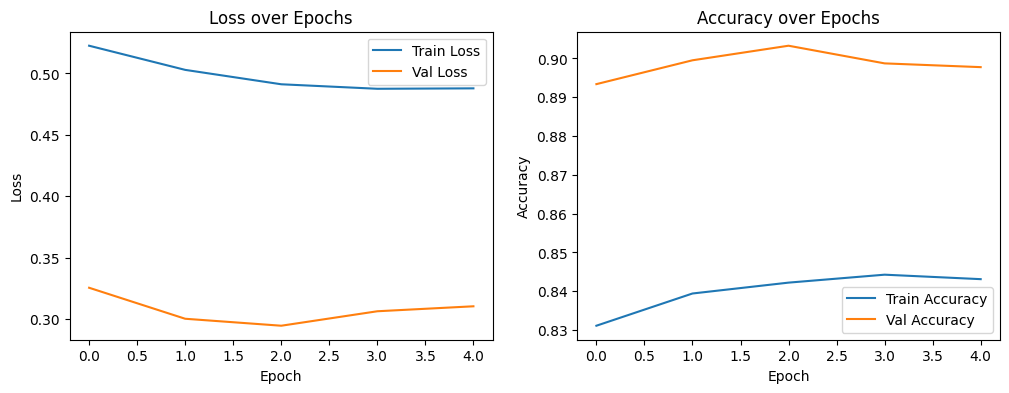

In [93]:
# Huấn luyện mô hình
model, history = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, patience=2, device=device)

# Lưu mô hình cuối cùng
save_path = os.path.join(os.getcwd(), 'plant_disease_model.pth')
torch.save(model.state_dict(), save_path)
print(f"Mô hình đã được lưu tại: {save_path}")

# Vẽ biểu đồ lịch sử huấn luyện
plt.figure(figsize=(12, 4))

# Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['val_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_accs'], label='Train Accuracy')
plt.plot(history['val_accs'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

In [ ]:
from torchvision.models import resnet18

def predict_disease(image_path):
    model = resnet18(weights=None)  # Không cần tải weights vì sẽ load từ file
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))
    model.load_state_dict(torch.load('plant_disease_model.pth', map_location=torch.device('cpu')))
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = data_transforms['val'](image)
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        disease = class_names[predicted.item()]
        confidence = confidence.item() * 100
    return disease, confidence

# Thử dự đoán
image_path = r"C:\Users\DELL\OneDrive - Hanoi University of Science and Technology\Desktop\dataset_plant\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train\Apple___Apple_scab\00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG"  # Cập nhật đường dẫn
disease, confidence = predict_disease(image_path)
print(f"Bệnh: {disease}, Độ tin cậy: {confidence:.2f}%")